We'll use The Corpus of Linguistic Acceptability (CoLA) dataset for single **sentence classification**. It's a set of sentences labeled as grammatically correct or incorrect. It was first published in May of 2018, and is one of the tests included in the "GLUE Benchmark" on which models like BERT are competing.

In [ ]:
!pip install transformers

We'll use the wget package to download the dataset to the Colab instance's file system.



In [ ]:
!pip install wget


In [ ]:
import torch
device = torch.device("cuda")

## **Downloading dataset**

In [ ]:
import wget
import os

print('Downloading dataset...')

# The URL for the dataset zip file.
url = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'

# Download the file (if we haven't already)
if not os.path.exists('./cola_public_1.1.zip'):
    wget.download(url, './cola_public_1.1.zip')

In [ ]:
# Unzip the dataset (if we haven't already)
if not os.path.exists('./cola_public/'):
    !unzip cola_public_1.1.zip

# **Importing dataset**

In [ ]:
import pandas as pd
data=pd.read_csv("./cola_public/raw/in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
data.head()

,sentence_source,label,label_notes,sentence
0,gj04,1,NaN,"Our friends won't buy this analysis, let alone..."
1,gj04,1,NaN,One more pseudo generalization and I'm giving up.
2,gj04,1,NaN,One more pseudo generalization or I'm giving up.
3,gj04,1,NaN,"The more we study verbs, the crazier they get."
4,gj04,1,NaN,Day by day the facts are getting murkier.


The two properties we actually care about are the the sentence and its label, which is referred to as the "acceptibility judgment" (0=unacceptable, 1=acceptable).



Let's extract the sentences and labels of our training set as numpy ndarrays.

In [ ]:
#Getting list of sentences and their labels
sentence=data.sentence.values
labels=data.label.values

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


## **Tokenize Dataset**

Before we are ready to encode our text, though, we need to decide on a maximum sentence length for padding / truncating to.

In [ ]:
max_len=0
for sent in sentence:
  input_ids=tokenizer.encode(sent)
  max_len=max(max_len,len(input_ids))
print('Max sentence length :',max_len)

Max sentence length : 47


Now we're ready to perform the real tokenization.

The tokenizer.encode_plus function combines multiple steps for us:

1.Split the sentence into tokens.

2.Add the special [CLS] and [SEP] tokens.

3.Map the tokens to their IDs.

4.Pad or truncate all sentences to the same length.

5.Create the attention masks which explicitly differentiate real tokens from [PAD] tokens.


In [ ]:
import torch
input_ids=[]
attention_masks=[]

for sent in sentence:
  encoded_dict=tokenizer.encode_plus(sent,
                                    add_special_tokens=True,
                                    max_length=64,
                                    pad_to_max_length=True,
                                    return_attention_mask=True,
                                    return_tensors='pt'
                                    )

  input_ids.append(encoded_dict['input_ids'])

  attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2143: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


## **Training & Validation Split**

Divide up our training set to use 90% for training and 10% for validation.

In [ ]:
"""# Use train_test_split to split our data into train and validation sets for
# training
from sklearn.model_selection import train_test_split

# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=2018, test_size=0.1)
"""

'from sklearn.model_selection import train_test_split\n\ntrain_dataset,val_dataset=train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)'

In [ ]:
"""from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)"""

In [ ]:
from torch.utils.data import TensorDataset,random_split

# Combine the training inputs into a TensorDataset.
#dataset = TensorDataset(input_ids, attention_masks, labels)
dataset = TensorDataset(input_ids, attention_masks, labels)

#creating 90% train and 10% validation data
train_size=int(0.9*len(dataset))
val_size=len(dataset)-train_size

train_dataset,val_dataset=random_split(dataset,[train_size,val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

7,695 training samples
  856 validation samples


We'll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.



In [ ]:
from torch.utils.data import DataLoader,RandomSampler,SequentialSampler

batch_size=32

# Create the DataLoaders for our training sets.
# We'll take training samples in random order. 
train_dataloader=DataLoader(train_dataset,
                            sampler=RandomSampler(train_dataset),
                            batch_size = batch_size
                            )

# Create the DataLoaders for our validation sets.
validation_dataloader=DataLoader(val_dataset,
                            sampler=SequentialSampler(val_dataset),
                            batch_size = batch_size
                            )

## **Train Our Classification Model**

For our task, we first modify the pre-trained BERT model to give outputs for classification, and then we want to continue training the model on our dataset until that the entire model, end-to-end, is well-suited for our task.


We'll be using BertForSequenceClassification. This is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task.

OK, let's load BERT! There are a few different pre-trained BERT models available. "bert-base-uncased" means the version that has only lowercase letters ("uncased") and is the smaller version of the two ("base" vs "large").

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 
model=BertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels = 2)
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

## **Optimizer & Learning Rate Scheduler**

Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend choosing from the following valuesin the BERT research paper

>- **Batch size:** 16, 32  
- **Learning rate (Adam):** 5e-5, 3e-5, 2e-5  
- **Number of epochs:** 2, 3, 4 

We chose:
* Batch size: 32 (set when creating our DataLoaders)
* Learning rate: 2e-5
* Epochs: 4 

we chooose The epsilon parameter `eps = 1e-8` is "a very small number to prevent any division by zero in the implementation".

we use AdamW optimizer for better results, You can find the creation of the AdamW optimizer in `run_glue.py` .

In [ ]:
# AdamW optimizwer is a class from the huggingface library (as opposed to pytorch) 
optimizer=AdamW(model.parameters(), 
               lr = 2e-5, 
               eps = 1e-8)

In [ ]:
from transformers import get_linear_schedule_with_warmup
epochs = 4               

total_steps=len(train_dataloader)*epochs    #[number of batches] x [number of epochs]

# Create the learning rate scheduler.
scheduler=get_linear_schedule_with_warmup(optimizer, 
                                         num_warmup_steps = 0, # Default value in run_glue.py
                                         num_training_steps = total_steps)

In [ ]:
"""
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=total_steps, num_warmup_steps=0)"""

'\nwarmup_steps = int(epochs * train_data_size * 0.1 / batch_size)\n\noptimizer = nlp.optimization.create_optimizer(\n    2e-5, num_train_steps=total_steps, num_warmup_steps=0)'

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
#Compile the model.

"""model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
"""
 

"model.compile(optimizer=optimizer,\n              loss='categorical_crossentropy',\n              metrics=['accuracy'])\n"

In [ ]:
"""model.fit(train_dataloader,
          validation_dataloader,
          epochs=epochs,
          batch_size=batch_size,
          validation_split=0.2,
          verbose=1)"""


'model.fit(train_dataloader,\n          validation_dataloader,\n          epochs=epochs,\n          batch_size=batch_size,\n          validation_split=0.2,\n          verbose=1)'

In [ ]:
"""loss, accuracy = model.evaluate(X_train, dummy_y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, dummy_y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))"""

'loss, accuracy = model.evaluate(X_train, dummy_y_train, verbose=False)\nprint("Training Accuracy: {:.4f}".format(accuracy))\nloss, accuracy = model.evaluate(X_test, dummy_y_test, verbose=False)\nprint("Testing Accuracy:  {:.4f}".format(accuracy))'

# We're ready to start our training and validation

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [ ]:
import random

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. As we unpack the batch, we'll also copy each tensor to the GPU using the `to` method.
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a backward pass. PyTorch doesn't do this automatically because 
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).This will return the loss (rather than the model output) because we have provided the `labels`.
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we cancalculate the average loss at the end.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.This will return the logits rather than the loss because we havenot provided labels.
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:15.
  Batch    80  of    241.    Elapsed: 0:00:32.
  Batch   120  of    241.    Elapsed: 0:00:48.
  Batch   160  of    241.    Elapsed: 0:01:03.
  Batch   200  of    241.    Elapsed: 0:01:18.
  Batch   240  of    241.    Elapsed: 0:01:33.

  Average training loss: 0.14
  Training epcoh took: 0:01:34

Running Validation...
  Accuracy: 0.82
  Validation took: 0:00:04

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:16.
  Batch    80  of    241.    Elapsed: 0:00:31.
  Batch   120  of    241.    Elapsed: 0:00:47.
  Batch   160  of    241.    Elapsed: 0:01:02.
  Batch   200  of    241.    Elapsed: 0:01:18.
  Batch   240  of    241.    Elapsed: 0:01:33.

  Average training loss: 0.22
  Training epcoh took: 0:01:34

Running Validation...
  Accuracy: 0.82
  Validation took: 0:00:04

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:16.
  

After training,we will visualize our traing loss


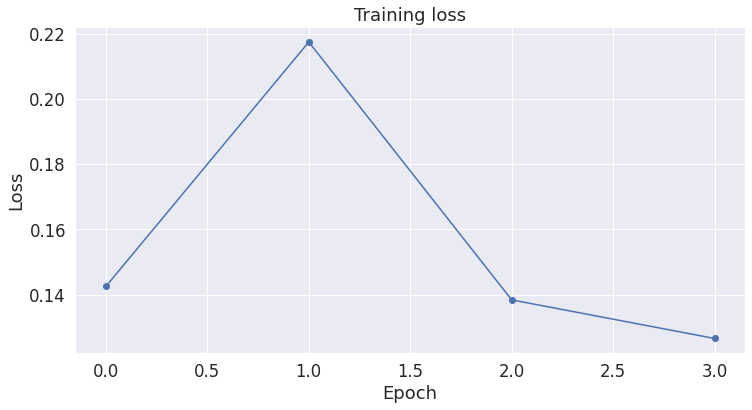

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

# **Performance On Test Set**
**Data Preparation**

Now we'll load the holdout dataset and prepare inputs just as we did with the training set. Then we'll evaluate predictions using Matthew's correlation coefficient because this is the metric used by the wider NLP community to evaluate performance on CoLA. With this metric, +1 is the best score, and -1 is the worst score. This way, we can see how well we perform against the state of the art models for this specific task.



In [ ]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv("./cola_public/raw/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
sentences = df.sentence.values
labels = df.label.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                     
                        add_special_tokens = True, 
                        max_length = 64,           
                        pad_to_max_length = True,
                        return_attention_mask = True,  
                        return_tensors = 'pt',     
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 516



/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2143: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


# Evaluate on Test Set
With the test set prepared, we can apply our fine-tuned model to generate predictions on the test set

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 516 test sentences...
    DONE.


In [ ]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


## **Final Acuuracy**

Now we'll combine the results for all of the batches and calculate our final MCC score.



In [ ]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.514


## **Saving models**

In [ ]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.txt',
 './model_save/added_tokens.json')